# Analyse de la Sortie de Vacance - Variables Territoriales
## Niveau Communal (France Métropolitaine)

---

**Objectif** : Analyser les facteurs territoriaux influençant le taux de sortie de vacance au niveau communal.

**Périmètre** : France métropolitaine uniquement (exclure DOM-TOM)

**Données** : `marts_analysis_city_aggregated`

---

## Plan d'analyse

1. Configuration et chargement des données
2. Exploration descriptive des variables territoriales
3. Analyse univariée : Impact de chaque variable territoriale
4. Analyse bivariée : Interactions entre variables
5. Modélisation multivariée
6. Profils territoriaux (clustering)
7. Cas extrêmes et recommandations


## 1. Configuration et chargement des données


In [1]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, classification_report
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Configuration matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

print("✅ Bibliothèques importées")


✅ Bibliothèques importées


In [3]:
# Connexion à MotherDuck
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'utils'))
from connection import get_connection, query_df, Tables

conn = get_connection()
print("✅ Connexion à MotherDuck établie")


Attempting to automatically open the SSO authorization page in your default browser.
Please open this link to login into your account: https://auth.motherduck.com/activate?user_code=DVCN-HLPH


Token successfully retrieved ✅

You can display the token and store it as an environment variable to avoid having to log in again:
  PRAGMA PRINT_MD_TOKEN;
✅ Connected to MotherDuck
✅ Connexion à MotherDuck établie


In [4]:
# Chargement des données - France métropolitaine uniquement
query = f"""
SELECT *
FROM {Tables.CITY_AGGREGATED}
WHERE geo_code NOT LIKE '97%'
  AND geo_code NOT LIKE '98%'
  AND total_housing_count > 0
"""

df_cities = query_df(query)
print(f"✅ {len(df_cities):,} communes chargées (France métropolitaine)")
print(f"   Colonnes: {len(df_cities.columns)}")
print(f"\nPremières lignes:")
df_cities.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ 34,619 communes chargées (France métropolitaine)
   Colonnes: 188

Premières lignes:


,geo_code,commune_name,total_housing_count,housing_out_count,still_vacant_count,exit_rate_pct,exit_rate_maisons_pct,exit_rate_appartements_pct,total_maisons,total_appartements,...,taux_tfnb,taux_th,teom_taux,th_surtaxe_indicateur,th_surtaxe_residences_secondaires_pct,pression_fiscale_tfb_teom,epci_regime_fiscal,fiscalite_annee_reference,vacancy_rate_vs_menages_pct,vacant_housing_per_1000_pop
0,01027,Balan,31,5.0,26.0,16.13,NaN,NaN,0.0,0.0,...,84.04,15.55,9.10,NON,NaN,36.92,FPU,2024,4.11,11.52
1,01191,Izenave,11,4.0,7.0,36.36,NaN,NaN,0.0,0.0,...,90.04,15.51,10.00,NON,NaN,36.13,FPU,2024,13.58,70.97
2,01224,Loyettes,60,26.0,34.0,43.33,NaN,NaN,0.0,0.0,...,113.28,19.92,7.11,NON,NaN,40.07,FPU,2024,4.50,17.75
3,01408,Simandre-sur-Suran,42,14.0,28.0,33.33,NaN,NaN,0.0,0.0,...,76.79,18.63,9.95,NON,NaN,39.07,FPU,2024,14.48,64.02
4,02099,Bonnesvalyn,12,3.0,9.0,25.00,NaN,NaN,0.0,0.0,...,61.07,20.97,NaN,NON,NaN,44.78,FPU,2024,13.95,56.87


In [5]:
# Métriques globales France métropolitaine
total_communes = len(df_cities)
total_logements = df_cities['total_housing_count'].sum()
total_sortis = df_cities['housing_out_count'].sum()
taux_sortie_moyen = df_cities['exit_rate_pct'].mean()
taux_sortie_median = df_cities['exit_rate_pct'].median()

print("=" * 70)
print("📊 MÉTRIQUES GLOBALES - FRANCE MÉTROPOLITAINE")
print("=" * 70)
print(f"Nombre de communes analysées : {total_communes:,}")
print(f"Total logements vacants : {total_logements:,}")
print(f"Total logements sortis de vacance : {total_sortis:,}")
print(f"Taux de sortie moyen : {taux_sortie_moyen:.2f}%")
print(f"Taux de sortie médian : {taux_sortie_median:.2f}%")
print(f"Écart-type : {df_cities['exit_rate_pct'].std():.2f}%")
print("=" * 70)


📊 MÉTRIQUES GLOBALES - FRANCE MÉTROPOLITAINE
Nombre de communes analysées : 34,619
Total logements vacants : 2,292,053
Total logements sortis de vacance : 1,062,832.0
Taux de sortie moyen : 39.16%
Taux de sortie médian : 39.58%
Écart-type : 16.24%


## 2. Exploration descriptive des variables territoriales


Distribution par densité (3 niveaux):
densite_category
Rural                   30416
Urbain dense              689
Urbain intermédiaire     3514
Name: count, dtype: int64



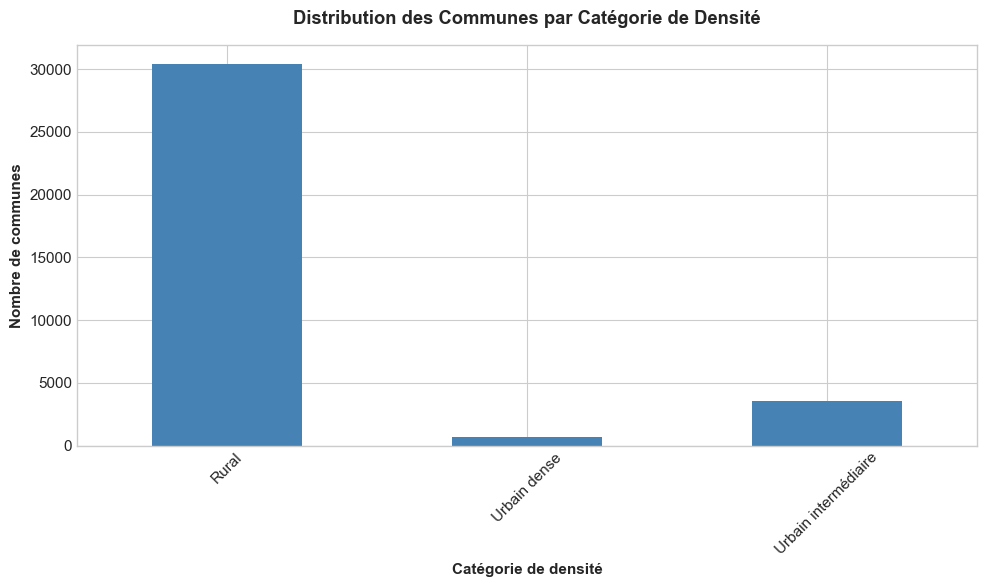

In [6]:
# Distribution par catégorie de densité (3 niveaux)
if 'densite_category' in df_cities.columns:
    densite_dist = df_cities['densite_category'].value_counts().sort_index()
    print("Distribution par densité (3 niveaux):")
    print(densite_dist)
    print()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    densite_dist.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Distribution des Communes par Catégorie de Densité', fontweight='bold', pad=15)
    ax.set_xlabel('Catégorie de densité', fontweight='bold')
    ax.set_ylabel('Nombre de communes', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()


Distribution par niveau de loyer:
niveau_loyer
Moyen         15433
Modéré        15152
Élevé          2951
Très élevé     1011
Faible           62
Name: count, dtype: int64



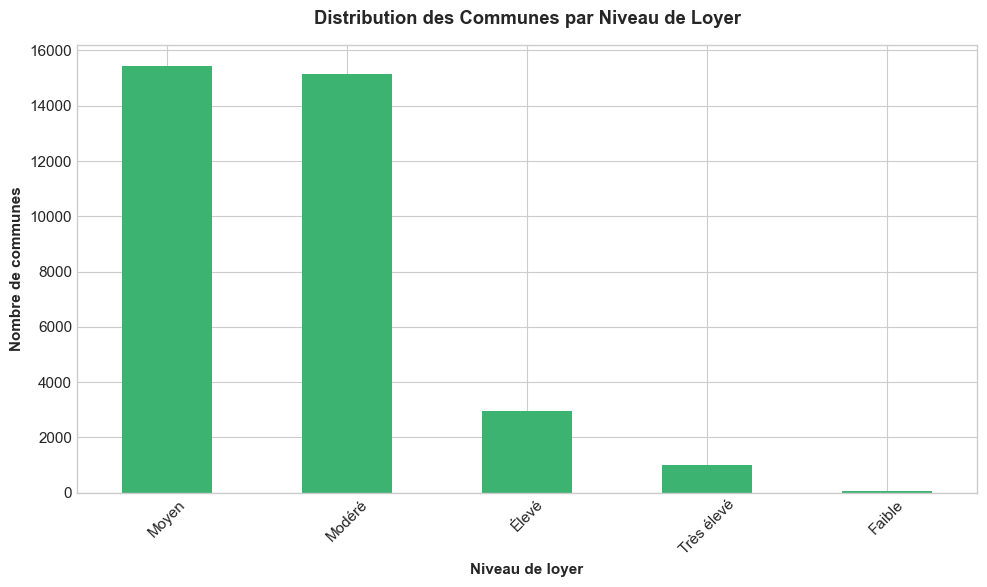

In [7]:
# Distribution par niveau de loyer
if 'niveau_loyer' in df_cities.columns:
    loyer_dist = df_cities['niveau_loyer'].value_counts()
    print("Distribution par niveau de loyer:")
    print(loyer_dist)
    print()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    loyer_dist.plot(kind='bar', ax=ax, color='mediumseagreen')
    ax.set_title('Distribution des Communes par Niveau de Loyer', fontweight='bold', pad=15)
    ax.set_xlabel('Niveau de loyer', fontweight='bold')
    ax.set_ylabel('Nombre de communes', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()


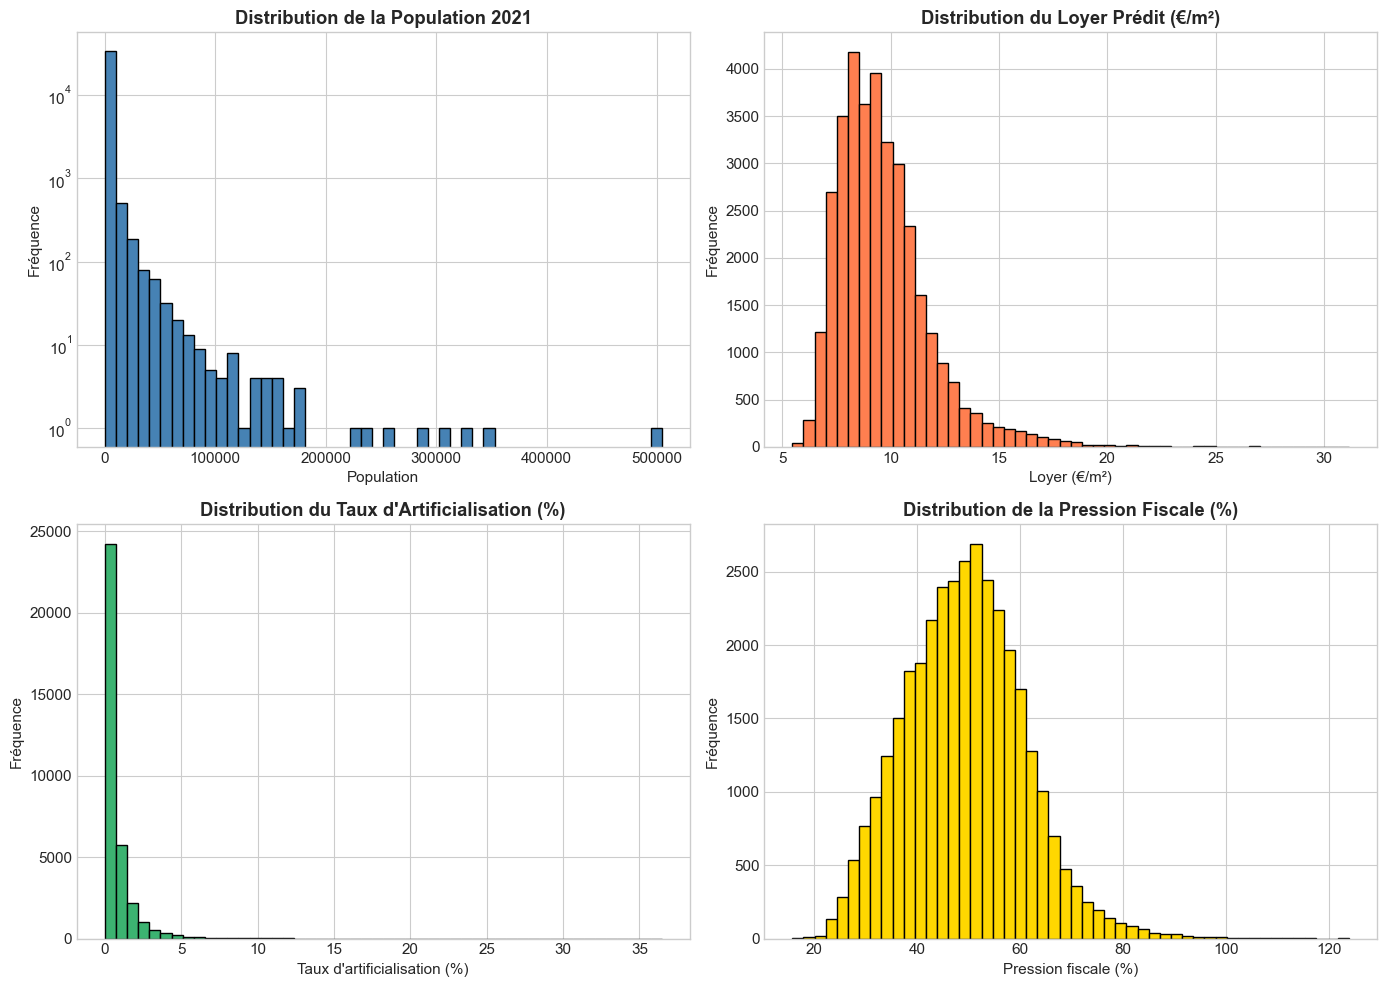

In [9]:
# Distribution des variables continues
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Population 2021
if 'population_2021' in df_cities.columns:
    df_cities['population_2021'].hist(bins=50, ax=axes[0, 0], color='steelblue', edgecolor='black')
    axes[0, 0].set_title('Distribution de la Population 2021', fontweight='bold')
    axes[0, 0].set_xlabel('Population')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].set_yscale('log')

# Loyer prédit
if 'loyer_predit_m2' in df_cities.columns:
    df_cities['loyer_predit_m2'].dropna().hist(bins=50, ax=axes[0, 1], color='coral', edgecolor='black')
    axes[0, 1].set_title('Distribution du Loyer Prédit (€/m²)', fontweight='bold')
    axes[0, 1].set_xlabel('Loyer (€/m²)')
    axes[0, 1].set_ylabel('Fréquence')

# Taux d'artificialisation
if 'taux_artificialisation_pct' in df_cities.columns:
    df_cities['taux_artificialisation_pct'].dropna().hist(bins=50, ax=axes[1, 0], color='mediumseagreen', edgecolor='black')
    axes[1, 0].set_title('Distribution du Taux d\'Artificialisation (%)', fontweight='bold')
    axes[1, 0].set_xlabel('Taux d\'artificialisation (%)')
    axes[1, 0].set_ylabel('Fréquence')

# Pression fiscale
if 'pression_fiscale_tfb_teom' in df_cities.columns:
    df_cities['pression_fiscale_tfb_teom'].dropna().hist(bins=50, ax=axes[1, 1], color='gold', edgecolor='black')
    axes[1, 1].set_title('Distribution de la Pression Fiscale (%)', fontweight='bold')
    axes[1, 1].set_xlabel('Pression fiscale (%)')
    axes[1, 1].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()


## 3. Analyse univariée : Impact de chaque variable territoriale


📊 TAUX DE SORTIE PAR CATÉGORIE DE DENSITÉ
                      taux_sortie_moyen  ecart_type  nb_communes  \
densite_category                                                   
Urbain dense                      49.24        9.28          689   
Urbain intermédiaire              45.36       11.11         3514   
Rural                             38.22       16.62        30416   

                      total_logements  logements_sortis  
densite_category                                         
Urbain dense                   561552          302225.0  
Urbain intermédiaire           654152          324211.0  
Rural                         1076349          436396.0  



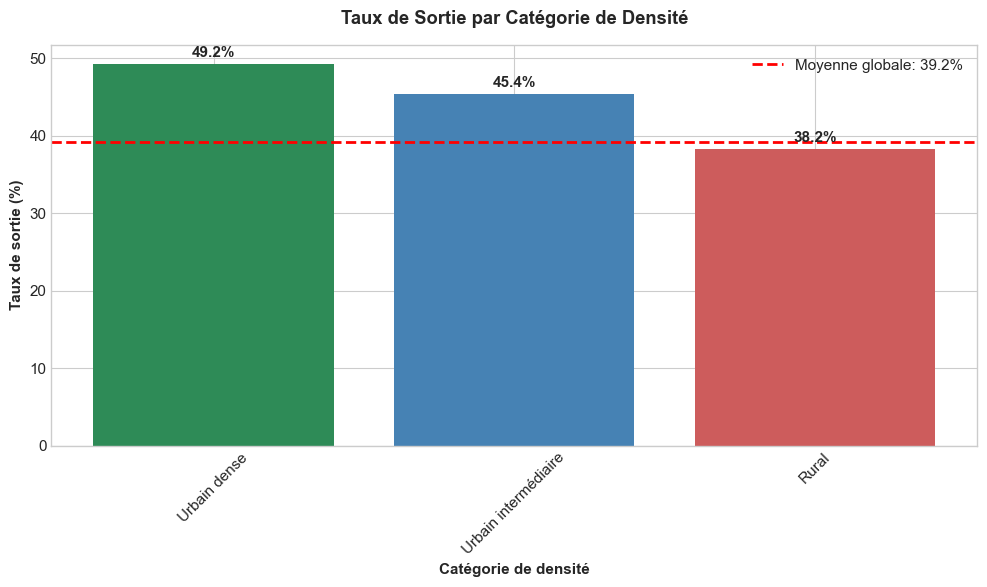

In [10]:
# Taux de sortie par catégorie de densité
if 'densite_category' in df_cities.columns:
    densite_exit = df_cities.groupby('densite_category').agg({
        'exit_rate_pct': ['mean', 'std', 'count'],
        'total_housing_count': 'sum',
        'housing_out_count': 'sum'
    }).round(2)
    
    densite_exit.columns = ['taux_sortie_moyen', 'ecart_type', 'nb_communes', 'total_logements', 'logements_sortis']
    densite_exit = densite_exit.sort_values('taux_sortie_moyen', ascending=False)
    
    print("=" * 70)
    print("📊 TAUX DE SORTIE PAR CATÉGORIE DE DENSITÉ")
    print("=" * 70)
    print(densite_exit)
    print()
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(densite_exit.index, densite_exit['taux_sortie_moyen'], 
                  color=['#2E8B57', '#4682B4', '#CD5C5C', '#FFA500'])
    ax.axhline(y=taux_sortie_moyen, color='red', linestyle='--', 
               linewidth=2, label=f'Moyenne globale: {taux_sortie_moyen:.1f}%')
    ax.set_title('Taux de Sortie par Catégorie de Densité', fontweight='bold', pad=15)
    ax.set_xlabel('Catégorie de densité', fontweight='bold')
    ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    
    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


📊 TAUX DE SORTIE PAR NIVEAU DE LOYER
              taux_sortie_moyen  ecart_type  nb_communes  total_logements
niveau_loyer                                                             
Très élevé                45.19       12.61         1011           287703
Élevé                     43.73       14.55         2951           432082
Moyen                     40.26       16.49        15433           959303
Modéré                    36.79       16.09        15152           609972
Faible                    34.34       10.59           62             2750



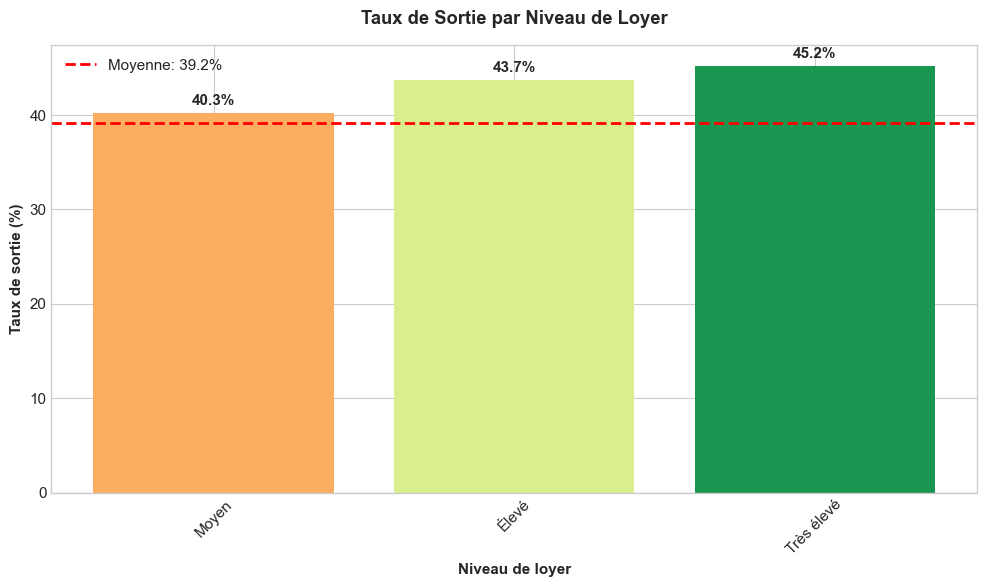

In [11]:
# Taux de sortie par niveau de loyer
if 'niveau_loyer' in df_cities.columns:
    loyer_exit = df_cities.groupby('niveau_loyer').agg({
        'exit_rate_pct': ['mean', 'std', 'count'],
        'total_housing_count': 'sum'
    }).round(2)
    
    loyer_exit.columns = ['taux_sortie_moyen', 'ecart_type', 'nb_communes', 'total_logements']
    loyer_exit = loyer_exit.sort_values('taux_sortie_moyen', ascending=False)
    
    print("=" * 70)
    print("📊 TAUX DE SORTIE PAR NIVEAU DE LOYER")
    print("=" * 70)
    print(loyer_exit)
    print()
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(10, 6))
    order = ['Très bas', 'Bas', 'Moyen', 'Élevé', 'Très élevé']
    loyer_exit_ordered = loyer_exit.reindex([x for x in order if x in loyer_exit.index])
    
    bars = ax.bar(loyer_exit_ordered.index, loyer_exit_ordered['taux_sortie_moyen'], 
                  color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(loyer_exit_ordered))))
    ax.axhline(y=taux_sortie_moyen, color='red', linestyle='--', 
               linewidth=2, label=f'Moyenne: {taux_sortie_moyen:.1f}%')
    ax.set_title('Taux de Sortie par Niveau de Loyer', fontweight='bold', pad=15)
    ax.set_xlabel('Niveau de loyer', fontweight='bold')
    ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


📊 TAUX DE SORTIE PAR DYNAMISME DU MARCHÉ
                      taux_sortie_moyen  ecart_type  nb_communes  \
dvg_marche_dynamisme                                               
Très dynamique                    44.19        9.77         7470   
Dynamique                         39.32       12.77        10611   
Modéré                            36.89       17.59         9943   
Faible                            34.92       23.82         4872   

                      total_logements  
dvg_marche_dynamisme                   
Très dynamique                1616394  
Dynamique                      368964  
Modéré                         157616  
Faible                          40887  



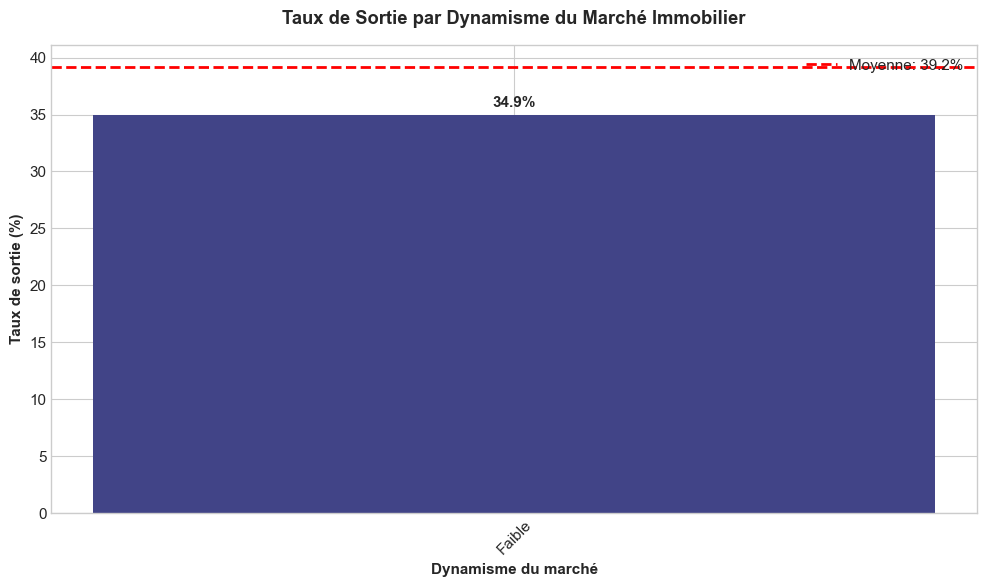

In [12]:
# Taux de sortie par dynamisme du marché
if 'dvg_marche_dynamisme' in df_cities.columns:
    marche_exit = df_cities.groupby('dvg_marche_dynamisme').agg({
        'exit_rate_pct': ['mean', 'std', 'count'],
        'total_housing_count': 'sum'
    }).round(2)
    
    marche_exit.columns = ['taux_sortie_moyen', 'ecart_type', 'nb_communes', 'total_logements']
    marche_exit = marche_exit.sort_values('taux_sortie_moyen', ascending=False)
    
    print("=" * 70)
    print("📊 TAUX DE SORTIE PAR DYNAMISME DU MARCHÉ")
    print("=" * 70)
    print(marche_exit)
    print()
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(10, 6))
    order = ['Très faible', 'Faible', 'Moyen', 'Élevé', 'Très élevé']
    marche_exit_ordered = marche_exit.reindex([x for x in order if x in marche_exit.index])
    
    bars = ax.bar(marche_exit_ordered.index, marche_exit_ordered['taux_sortie_moyen'],
                  color=plt.cm.viridis(np.linspace(0.2, 0.8, len(marche_exit_ordered))))
    ax.axhline(y=taux_sortie_moyen, color='red', linestyle='--', 
               linewidth=2, label=f'Moyenne: {taux_sortie_moyen:.1f}%')
    ax.set_title('Taux de Sortie par Dynamisme du Marché Immobilier', fontweight='bold', pad=15)
    ax.set_xlabel('Dynamisme du marché', fontweight='bold')
    ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


📊 TAUX DE SORTIE PAR DYNAMIQUE DÉMOGRAPHIQUE
                              taux_sortie_moyen  ecart_type  nb_communes  \
Population stable/croissante              39.91       16.07        18498   
Population en déclin                      38.30       16.39        16121   

                              total_logements  
Population stable/croissante          1342909  
Population en déclin                   949144  

Test t de Student: t=-9.205, p-value=0.0000
✅ Différence statistiquement significative (p < 0.05)



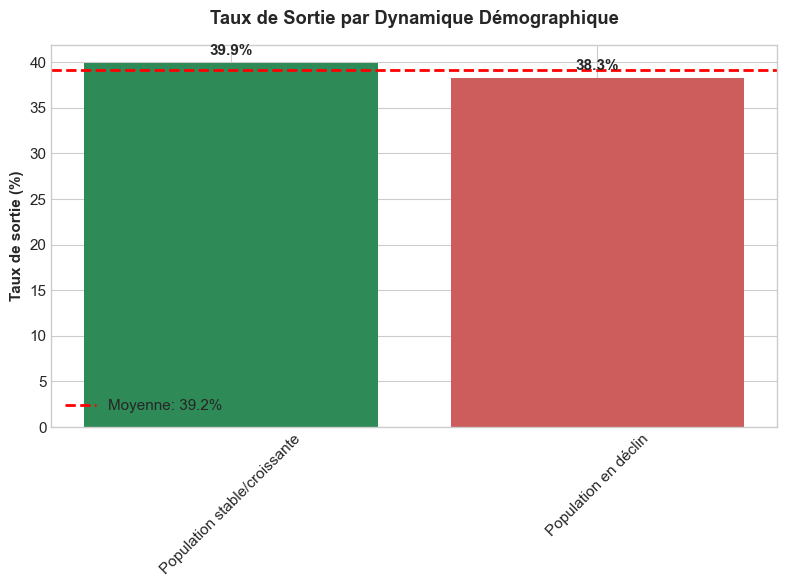

In [13]:
# Taux de sortie par dynamique démographique
if 'is_population_declining' in df_cities.columns:
    demo_exit = df_cities.groupby('is_population_declining').agg({
        'exit_rate_pct': ['mean', 'std', 'count'],
        'total_housing_count': 'sum'
    }).round(2)
    
    demo_exit.columns = ['taux_sortie_moyen', 'ecart_type', 'nb_communes', 'total_logements']
    demo_exit.index = ['Population stable/croissante', 'Population en déclin']
    
    print("=" * 70)
    print("📊 TAUX DE SORTIE PAR DYNAMIQUE DÉMOGRAPHIQUE")
    print("=" * 70)
    print(demo_exit)
    print()
    
    # Test statistique
    declining = df_cities[df_cities['is_population_declining'] == True]['exit_rate_pct'].dropna()
    stable = df_cities[df_cities['is_population_declining'] == False]['exit_rate_pct'].dropna()
    
    if len(declining) > 0 and len(stable) > 0:
        t_stat, p_value = stats.ttest_ind(declining, stable)
        print(f"Test t de Student: t={t_stat:.3f}, p-value={p_value:.4f}")
        if p_value < 0.05:
            print("✅ Différence statistiquement significative (p < 0.05)")
        else:
            print("❌ Différence non significative (p >= 0.05)")
        print()
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(demo_exit.index, demo_exit['taux_sortie_moyen'], 
                  color=['#2E8B57', '#CD5C5C'])
    ax.axhline(y=taux_sortie_moyen, color='red', linestyle='--', 
               linewidth=2, label=f'Moyenne: {taux_sortie_moyen:.1f}%')
    ax.set_title('Taux de Sortie par Dynamique Démographique', fontweight='bold', pad=15)
    ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


📊 TAUX DE SORTIE PAR TAUX D'ARTIFICIALISATION
                       taux_sortie_moyen  ecart_type  nb_communes  \
artificialisation_bin                                               
Très faible (<5%)                  39.14       16.12        33735   
Faible (5-10%)                     45.02       13.51          365   
Modéré (10-20%)                    48.07       16.69           37   
Élevé (20-40%)                     54.94       19.90            4   
Très élevé (>40%)                    NaN         NaN            0   

                       total_logements  
artificialisation_bin                   
Très faible (<5%)              2207725  
Faible (5-10%)                   37475  
Modéré (10-20%)                   3760  
Élevé (20-40%)                     473  
Très élevé (>40%)                    0  



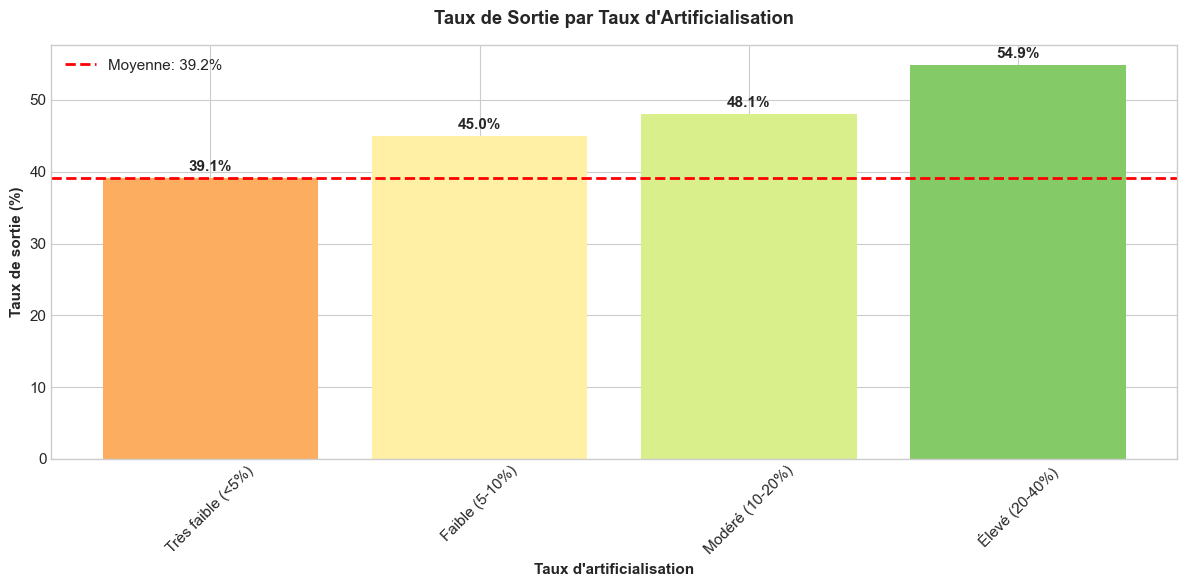

In [14]:
# Taux de sortie par taux d'artificialisation (bins)
if 'taux_artificialisation_pct' in df_cities.columns:
    df_cities['artificialisation_bin'] = pd.cut(
        df_cities['taux_artificialisation_pct'].dropna(),
        bins=[0, 5, 10, 20, 40, 100],
        labels=['Très faible (<5%)', 'Faible (5-10%)', 'Modéré (10-20%)', 
                'Élevé (20-40%)', 'Très élevé (>40%)']
    )
    
    art_exit = df_cities.groupby('artificialisation_bin').agg({
        'exit_rate_pct': ['mean', 'std', 'count'],
        'total_housing_count': 'sum'
    }).round(2)
    
    art_exit.columns = ['taux_sortie_moyen', 'ecart_type', 'nb_communes', 'total_logements']
    
    print("=" * 70)
    print("📊 TAUX DE SORTIE PAR TAUX D'ARTIFICIALISATION")
    print("=" * 70)
    print(art_exit)
    print()
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(art_exit.index, art_exit['taux_sortie_moyen'],
                  color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(art_exit))))
    ax.axhline(y=taux_sortie_moyen, color='red', linestyle='--', 
               linewidth=2, label=f'Moyenne: {taux_sortie_moyen:.1f}%')
    ax.set_title('Taux de Sortie par Taux d\'Artificialisation', fontweight='bold', pad=15)
    ax.set_xlabel('Taux d\'artificialisation', fontweight='bold')
    ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


## 4. Analyse bivariée : Interactions entre variables


📊 TAUX DE SORTIE : DENSITÉ × NIVEAU DE LOYER
niveau_loyer          Faible  Modéré  Moyen  Très élevé  Élevé
densite_category                                              
Rural                  34.34   36.65  39.44       41.38  41.94
Urbain dense             NaN   56.16  50.50       47.45  51.23
Urbain intermédiaire     NaN   43.80  45.59       45.97  45.21



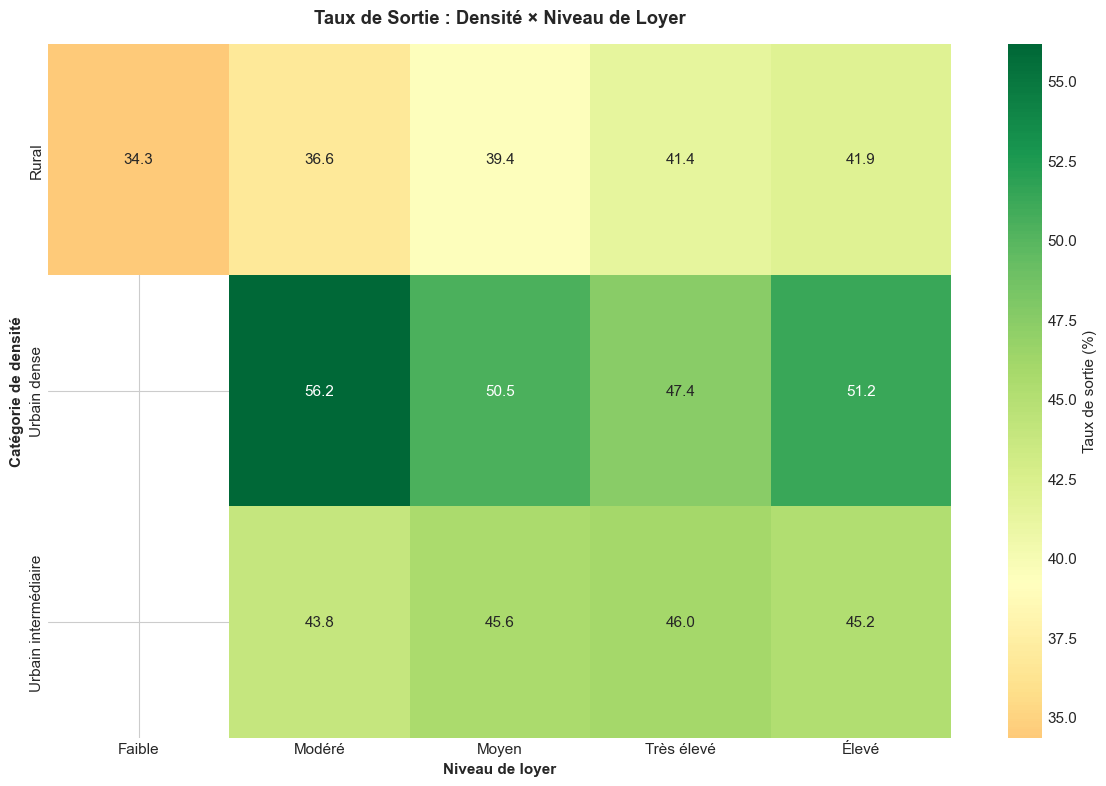

In [15]:
# Heatmap : Densité × Niveau de loyer
if 'densite_category' in df_cities.columns and 'niveau_loyer' in df_cities.columns:
    pivot_densite_loyer = df_cities.pivot_table(
        values='exit_rate_pct',
        index='densite_category',
        columns='niveau_loyer',
        aggfunc='mean'
    )
    
    print("=" * 70)
    print("📊 TAUX DE SORTIE : DENSITÉ × NIVEAU DE LOYER")
    print("=" * 70)
    print(pivot_densite_loyer.round(2))
    print()
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(pivot_densite_loyer, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=taux_sortie_moyen, ax=ax, cbar_kws={'label': 'Taux de sortie (%)'})
    ax.set_title('Taux de Sortie : Densité × Niveau de Loyer', fontweight='bold', pad=15)
    ax.set_xlabel('Niveau de loyer', fontweight='bold')
    ax.set_ylabel('Catégorie de densité', fontweight='bold')
    plt.tight_layout()
    plt.show()


📊 TAUX DE SORTIE : DENSITÉ × DYNAMISME MARCHÉ
dvg_marche_dynamisme  Dynamique  Faible  Modéré  Très dynamique
densite_category                                               
Rural                     39.14   34.91   36.87           42.27
Urbain dense              52.11     NaN     NaN           49.05
Urbain intermédiaire      42.26   46.10   40.46           46.20



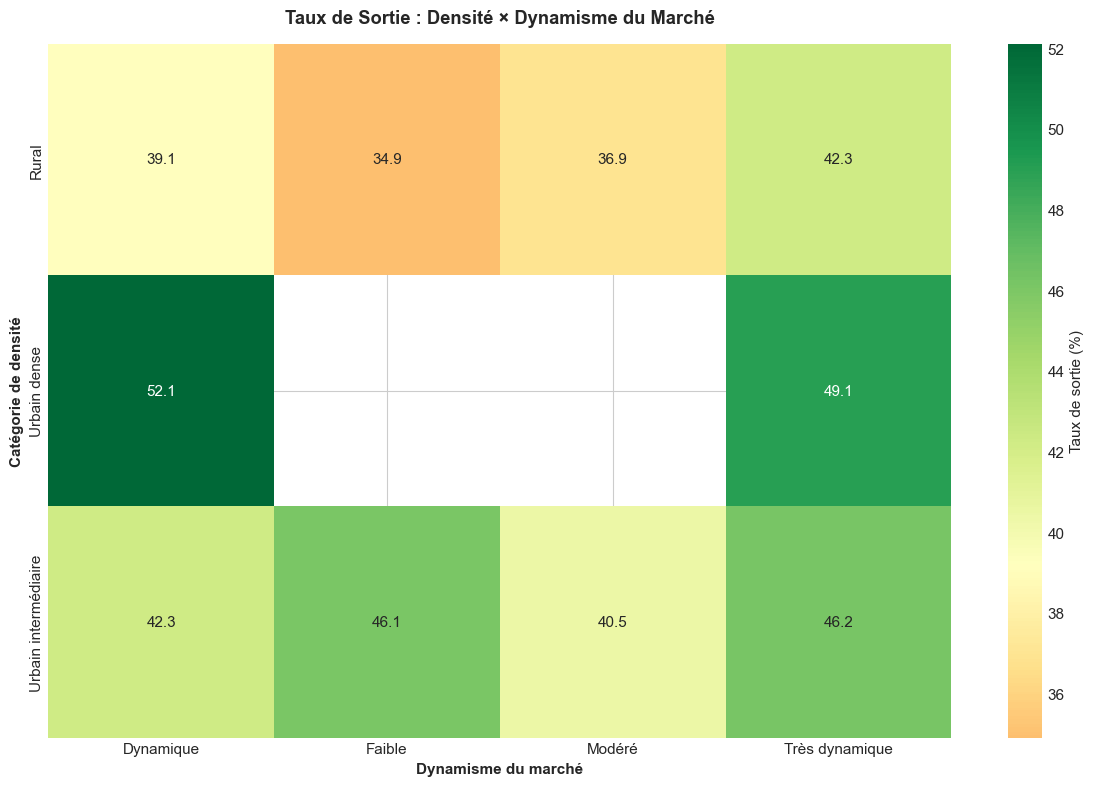

In [16]:
# Heatmap : Densité × Dynamisme marché
if 'densite_category' in df_cities.columns and 'dvg_marche_dynamisme' in df_cities.columns:
    pivot_densite_marche = df_cities.pivot_table(
        values='exit_rate_pct',
        index='densite_category',
        columns='dvg_marche_dynamisme',
        aggfunc='mean'
    )
    
    print("=" * 70)
    print("📊 TAUX DE SORTIE : DENSITÉ × DYNAMISME MARCHÉ")
    print("=" * 70)
    print(pivot_densite_marche.round(2))
    print()
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(pivot_densite_marche, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=taux_sortie_moyen, ax=ax, cbar_kws={'label': 'Taux de sortie (%)'})
    ax.set_title('Taux de Sortie : Densité × Dynamisme du Marché', fontweight='bold', pad=15)
    ax.set_xlabel('Dynamisme du marché', fontweight='bold')
    ax.set_ylabel('Catégorie de densité', fontweight='bold')
    plt.tight_layout()
    plt.show()


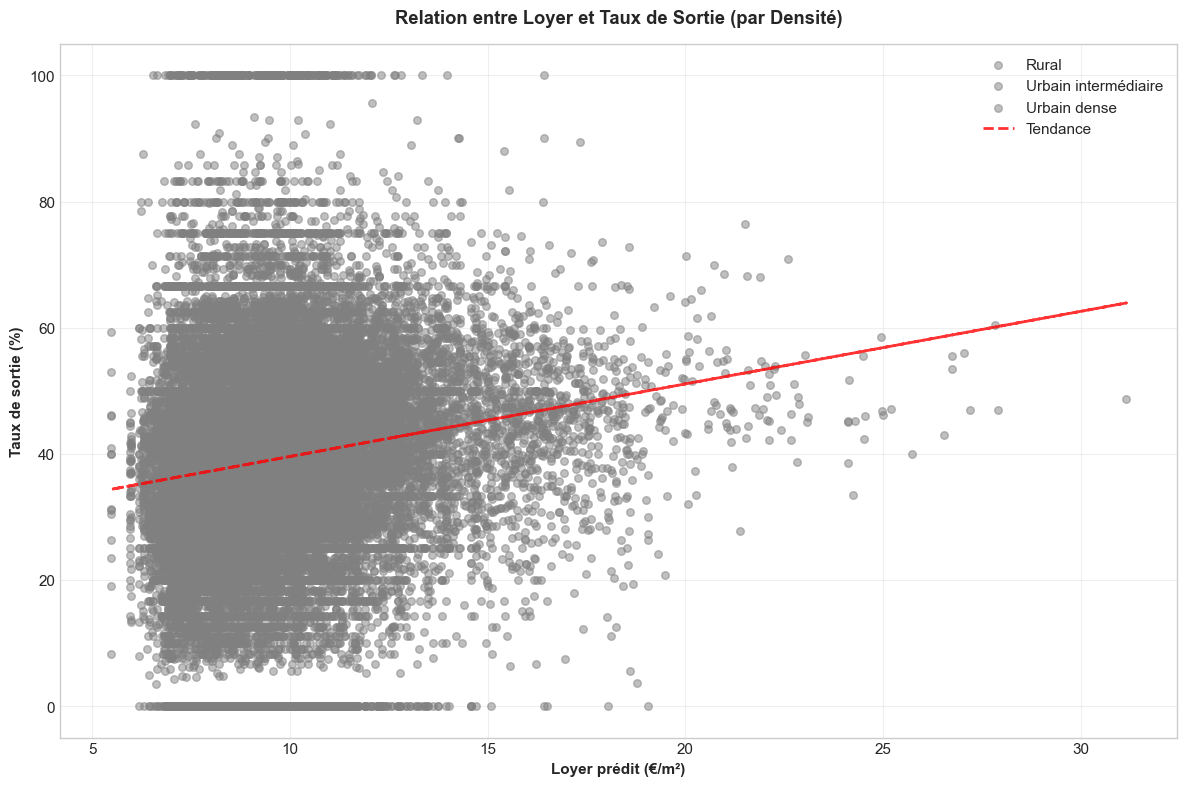

Corrélation loyer - taux de sortie : 0.154


In [17]:
# Scatter plot : Loyer prédit vs Taux de sortie (coloré par densité)
if 'loyer_predit_m2' in df_cities.columns and 'densite_category' in df_cities.columns:
    df_plot = df_cities[['loyer_predit_m2', 'exit_rate_pct', 'densite_category']].dropna()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Colorer par densité
    colors_map = {'Dense': '#2E8B57', 'Intermédiaire': '#4682B4', 
                  'Peu dense': '#CD5C5C', 'Très peu dense': '#FFA500'}
    
    for densite in df_plot['densite_category'].unique():
        if pd.notna(densite):
            data = df_plot[df_plot['densite_category'] == densite]
            ax.scatter(data['loyer_predit_m2'], data['exit_rate_pct'], 
                      label=densite, alpha=0.5, s=30, color=colors_map.get(densite, 'gray'))
    
    # Régression linéaire globale
    z = np.polyfit(df_plot['loyer_predit_m2'], df_plot['exit_rate_pct'], 1)
    p = np.poly1d(z)
    ax.plot(df_plot['loyer_predit_m2'], p(df_plot['loyer_predit_m2']), 
           "r--", alpha=0.8, linewidth=2, label='Tendance')
    
    ax.set_xlabel('Loyer prédit (€/m²)', fontweight='bold')
    ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
    ax.set_title('Relation entre Loyer et Taux de Sortie (par Densité)', fontweight='bold', pad=15)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Corrélation
    corr = df_plot['loyer_predit_m2'].corr(df_plot['exit_rate_pct'])
    print(f"Corrélation loyer - taux de sortie : {corr:.3f}")


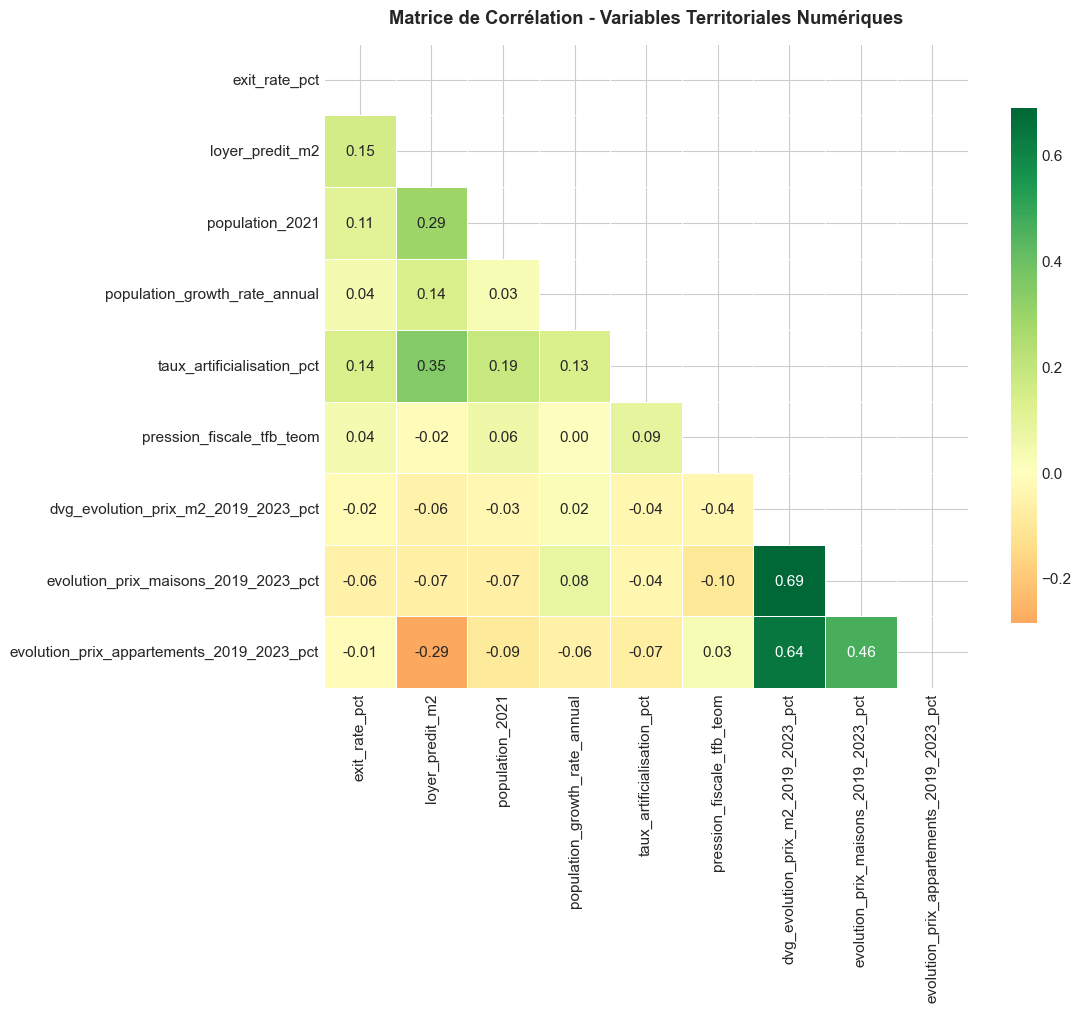

In [18]:
# Matrice de corrélation des variables numériques territoriales
numeric_cols = [
    'exit_rate_pct', 'loyer_predit_m2', 'population_2021', 
    'population_growth_rate_annual', 'taux_artificialisation_pct',
    'pression_fiscale_tfb_teom', 'dvg_evolution_prix_m2_2019_2023_pct',
    'evolution_prix_maisons_2019_2023_pct', 'evolution_prix_appartements_2019_2023_pct'
]

# Filtrer les colonnes qui existent
numeric_cols = [col for col in numeric_cols if col in df_cities.columns]
df_corr = df_cities[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn', 
           center=0, square=True, linewidths=0.5, ax=ax,
           cbar_kws={'shrink': 0.8})
ax.set_title('Matrice de Corrélation - Variables Territoriales Numériques', 
            fontweight='bold', pad=15)
plt.tight_layout()
plt.show()


## 5. Modélisation multivariée


In [19]:
# Préparation des données pour la modélisation
# Sélection des variables territoriales pertinentes
territorial_features = [
    'loyer_predit_m2', 'population_2021', 'population_growth_rate_annual',
    'taux_artificialisation_pct', 'pression_fiscale_tfb_teom',
    'dvg_evolution_prix_m2_2019_2023_pct', 'evolution_prix_maisons_2019_2023_pct'
]

# Variables catégorielles à encoder
categorical_features = ['densite_category', 'niveau_loyer', 'dvg_marche_dynamisme']

# Créer un dataset pour la modélisation
df_model = df_cities[['exit_rate_pct'] + territorial_features + categorical_features].copy()

# Filtrer les colonnes qui existent
territorial_features = [col for col in territorial_features if col in df_model.columns]
categorical_features = [col for col in categorical_features if col in df_model.columns]

# Encoder les variables catégorielles
le_dict = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[f'{col}_encoded'] = le.fit_transform(df_model[col].astype(str))
    le_dict[col] = le

# Remplacer les valeurs manquantes par la médiane
for col in territorial_features:
    df_model[col] = df_model[col].fillna(df_model[col].median())

# Supprimer les lignes avec valeurs manquantes pour la target
df_model = df_model.dropna(subset=['exit_rate_pct'])

print(f"✅ Dataset pour modélisation : {len(df_model)} communes")
print(f"   Variables numériques : {len(territorial_features)}")
print(f"   Variables catégorielles : {len(categorical_features)}")


✅ Dataset pour modélisation : 34619 communes
   Variables numériques : 7
   Variables catégorielles : 3


In [20]:
# Régression linéaire : exit_rate_pct ~ variables territoriales
X_cols = territorial_features + [f'{col}_encoded' for col in categorical_features]
X = df_model[X_cols]
y = df_model['exit_rate_pct']

# Standardiser les features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modèle de régression linéaire
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prédictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Métriques
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("=" * 70)
print("📊 RÉGRESSION LINÉAIRE - TAUX DE SORTIE")
print("=" * 70)
print(f"R² (train) : {r2_train:.3f}")
print(f"R² (test)  : {r2_test:.3f}")
print(f"RMSE (test): {rmse_test:.2f}%")
print()

# Coefficients
coef_df = pd.DataFrame({
    'feature': X_cols,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("Top 10 variables les plus importantes:")
print(coef_df.head(10).to_string(index=False))


📊 RÉGRESSION LINÉAIRE - TAUX DE SORTIE
R² (train) : 0.040
R² (test)  : 0.044
RMSE (test): 15.75%

Top 10 variables les plus importantes:
                             feature  coefficient  abs_coefficient
                     loyer_predit_m2     1.182264         1.182264
          taux_artificialisation_pct     0.942241         0.942241
            densite_category_encoded     0.892215         0.892215
                     population_2021     0.683030         0.683030
        dvg_marche_dynamisme_encoded     0.674610         0.674610
           pression_fiscale_tfb_teom     0.475324         0.475324
                niveau_loyer_encoded     0.224459         0.224459
       population_growth_rate_annual     0.175103         0.175103
 dvg_evolution_prix_m2_2019_2023_pct    -0.099418         0.099418
evolution_prix_maisons_2019_2023_pct     0.003824         0.003824


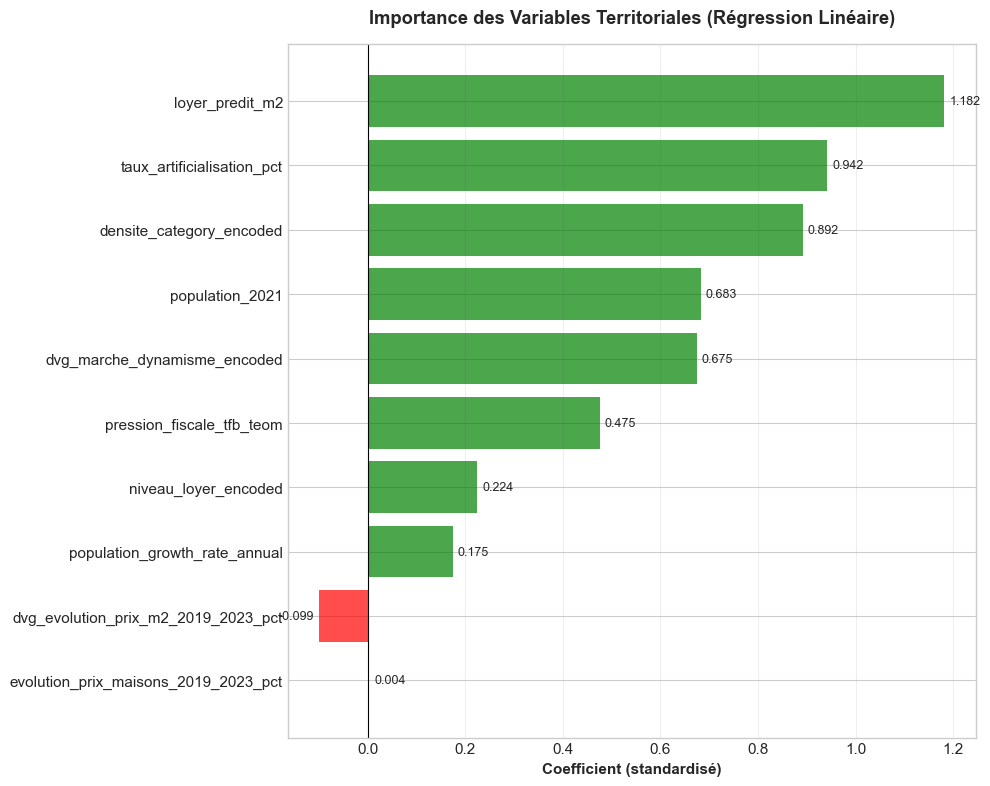

In [21]:
# Visualisation de l'importance des variables
fig, ax = plt.subplots(figsize=(10, 8))
top_features = coef_df.head(15)
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
bars = ax.barh(top_features['feature'], top_features['coefficient'], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Coefficient (standardisé)', fontweight='bold')
ax.set_title('Importance des Variables Territoriales (Régression Linéaire)', fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Ajouter les valeurs
for bar in bars:
    width = bar.get_width()
    ax.text(width + (0.01 if width > 0 else -0.01), bar.get_y() + bar.get_height()/2,
           f'{width:.3f}', ha='left' if width > 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [22]:
# Régression logistique : is_high_exit_rate (>50%) ~ variables
df_model['is_high_exit'] = (df_model['exit_rate_pct'] > 50).astype(int)

X = df_model[X_cols]
y = df_model['is_high_exit']

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Modèle de régression logistique
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Prédictions
y_pred_test = log_model.predict(X_test)
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Métriques
auc = roc_auc_score(y_test, y_pred_proba)
print("=" * 70)
print("📊 RÉGRESSION LOGISTIQUE - COMMUNES À FORT TAUX DE SORTIE (>50%)")
print("=" * 70)
print(f"AUC-ROC : {auc:.3f}")
print()
print("Rapport de classification:")
print(classification_report(y_test, y_pred_test))
print()

# Odds Ratios
odds_ratios = pd.DataFrame({
    'feature': X_cols,
    'coefficient': log_model.coef_[0],
    'odds_ratio': np.exp(log_model.coef_[0]),
    'abs_coefficient': np.abs(log_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 10 variables par Odds Ratio:")
print(odds_ratios.head(10).to_string(index=False))


📊 RÉGRESSION LOGISTIQUE - COMMUNES À FORT TAUX DE SORTIE (>50%)
AUC-ROC : 0.610

Rapport de classification:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      5593
           1       0.47      0.02      0.05      1331

    accuracy                           0.81      6924
   macro avg       0.64      0.51      0.47      6924
weighted avg       0.75      0.81      0.73      6924


Top 10 variables par Odds Ratio:
                             feature  coefficient  odds_ratio  abs_coefficient
                     population_2021     0.178798    1.195779         0.178798
                niveau_loyer_encoded     0.132294    1.141444         0.132294
            densite_category_encoded     0.088720    1.092775         0.088720
                     loyer_predit_m2     0.073884    1.076682         0.073884
          taux_artificialisation_pct     0.070947    1.073524         0.070947
        dvg_marche_dynamisme_encoded     0.056039    1.05

📊 RANDOM FOREST - IMPORTANCE DES VARIABLES
R² (test) : 0.008

Top 15 variables les plus importantes:
                             feature  importance
                     population_2021    0.167083
           pression_fiscale_tfb_teom    0.164934
          taux_artificialisation_pct    0.158908
                     loyer_predit_m2    0.158106
       population_growth_rate_annual    0.144022
 dvg_evolution_prix_m2_2019_2023_pct    0.130496
evolution_prix_maisons_2019_2023_pct    0.041592
        dvg_marche_dynamisme_encoded    0.018545
            densite_category_encoded    0.013028
                niveau_loyer_encoded    0.003285



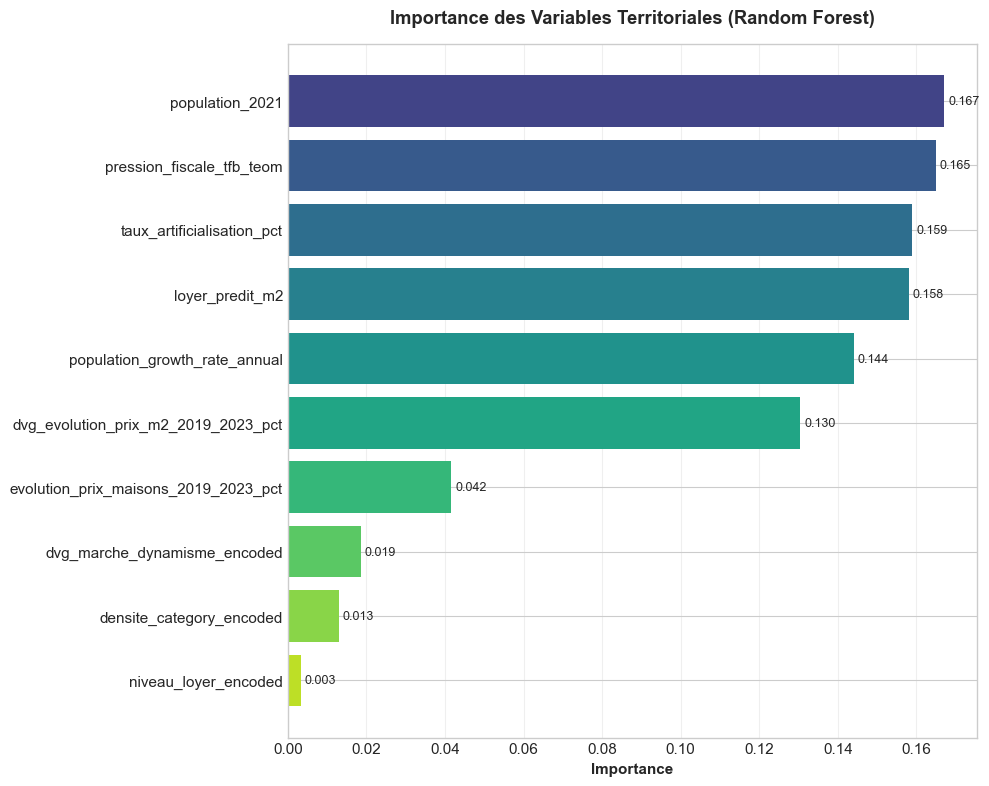

In [23]:
# Random Forest pour l'importance des variables
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Importance des features
feature_importance = pd.DataFrame({
    'feature': X_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=" * 70)
print("📊 RANDOM FOREST - IMPORTANCE DES VARIABLES")
print("=" * 70)
print(f"R² (test) : {r2_score(y_test, rf_model.predict(X_test)):.3f}")
print()
print("Top 15 variables les plus importantes:")
print(feature_importance.head(15).to_string(index=False))
print()

# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
bars = ax.barh(top_features['feature'], top_features['importance'], 
              color=plt.cm.viridis(np.linspace(0.2, 0.9, len(top_features))))
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title('Importance des Variables Territoriales (Random Forest)', fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
           f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()


## 6. Profils territoriaux (clustering)


In [24]:
# Préparation des données pour le clustering
# Variables territoriales normalisées
cluster_features = [
    'loyer_predit_m2', 'population_2021', 'population_growth_rate_annual',
    'taux_artificialisation_pct', 'pression_fiscale_tfb_teom',
    'dvg_evolution_prix_m2_2019_2023_pct'
]

# Filtrer les colonnes qui existent
cluster_features = [col for col in cluster_features if col in df_cities.columns]

df_cluster = df_cities[cluster_features + ['exit_rate_pct', 'densite_category']].copy()

# Remplacer les NaN par la médiane
for col in cluster_features:
    df_cluster[col] = df_cluster[col].fillna(df_cluster[col].median())

# Standardiser
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_cluster[cluster_features])

# K-means clustering (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_cluster)

# Caractéristiques par cluster
cluster_summary = df_cluster.groupby('cluster').agg({
    'exit_rate_pct': 'mean',
    **{col: 'mean' for col in cluster_features},
    'densite_category': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A'
}).round(2)

cluster_summary['nb_communes'] = df_cluster.groupby('cluster').size()

print("=" * 70)
print("📊 PROFILS TERRITORIAUX (4 CLUSTERS)")
print("=" * 70)
print(cluster_summary)
print()


📊 PROFILS TERRITORIAUX (4 CLUSTERS)
         exit_rate_pct  loyer_predit_m2  population_2021  \
cluster                                                    
0                37.64             8.92           624.22   
1                39.01             9.33          1017.28   
2                44.51            13.07          6179.54   
3                53.72            15.48        132974.25   

         population_growth_rate_annual  taux_artificialisation_pct  \
cluster                                                              
0                                -0.03                        0.40   
1                                 0.03                        0.53   
2                                 1.29                        2.47   
3                                 0.46                        1.40   

         pression_fiscale_tfb_teom  dvg_evolution_prix_m2_2019_2023_pct  \
cluster                                                                   
0                            40.

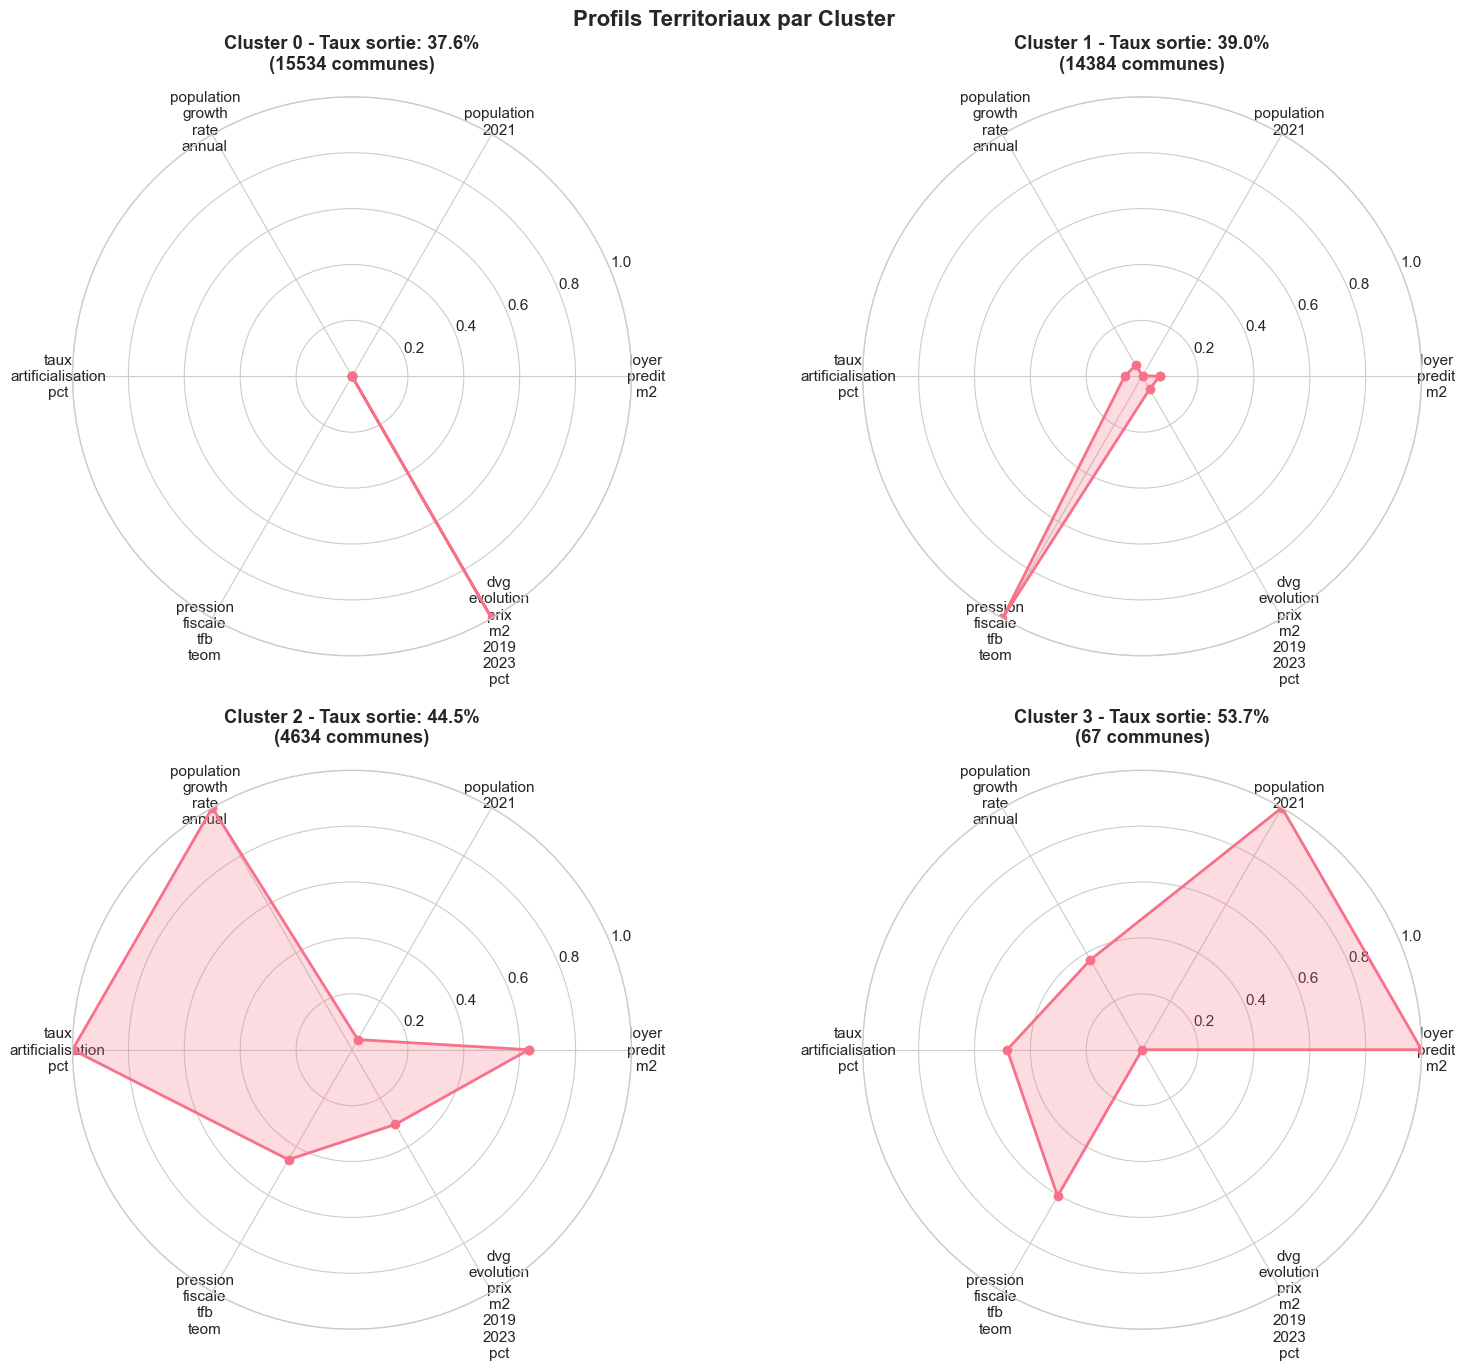

In [ ]:
# Visualisation des profils (Radar chart)
from math import pi

# Préparer les données pour le radar chart
categories = [col.replace('_', '\n') for col in cluster_features]

# Normaliser les valeurs pour le radar chart (0-1)
cluster_normalized = cluster_summary[cluster_features].copy()
for col in cluster_features:
    min_val = cluster_normalized[col].min()
    max_val = cluster_normalized[col].max()
    if max_val > min_val:
        cluster_normalized[col] = (cluster_normalized[col] - min_val) / (max_val - min_val)
    else:
        cluster_normalized[col] = 0.5

# Créer le radar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 14), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

for idx, cluster_id in enumerate(cluster_summary.index):
    ax = axes[idx]
    
    # Angles pour chaque catégorie
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]  # Fermer le cercle
    
    # Valeurs pour ce cluster
    values = [cluster_normalized.loc[cluster_id, col] for col in cluster_features]
    values += values[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {cluster_id} - Taux sortie: {cluster_summary.loc[cluster_id, "exit_rate_pct"]:.1f}%\n'
                f'({cluster_summary.loc[cluster_id, "nb_communes"]} communes)', 
                fontweight='bold', pad=20)

plt.suptitle('Profils Territoriaux par Cluster', fontweight='bold', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


## 7. Cas extrêmes et recommandations


In [ ]:
# Communes avec taux de sortie très élevé (>80%)
high_exit = df_cities[
    (df_cities['exit_rate_pct'] >= 80) & 
    (df_cities['total_housing_count'] >= 50)
].sort_values('exit_rate_pct', ascending=False).head(20)

print("=" * 70)
print("📊 TOP 20 COMMUNES AVEC TAUX DE SORTIE TRÈS ÉLEVÉ (>80%)")
print("=" * 70)
if len(high_exit) > 0:
    display_cols = ['commune_name', 'geo_code', 'total_housing_count', 
                    'housing_out_count', 'exit_rate_pct', 'densite_category',
                    'population_2021', 'niveau_loyer', 'dvg_marche_dynamisme']
    display_cols = [col for col in display_cols if col in high_exit.columns]
    print(high_exit[display_cols].to_string())
    print()
    
    # Analyse des caractéristiques communes
    print("Caractéristiques moyennes des communes à fort taux de sortie:")
    if 'densite_category' in high_exit.columns:
        print(f"  Densité dominante: {high_exit['densite_category'].mode()[0] if len(high_exit['densite_category'].mode()) > 0 else 'N/A'}")
    if 'population_2021' in high_exit.columns:
        print(f"  Population moyenne: {high_exit['population_2021'].mean():.0f}")
    if 'loyer_predit_m2' in high_exit.columns:
        print(f"  Loyer moyen: {high_exit['loyer_predit_m2'].mean():.1f} €/m²")
    if 'taux_artificialisation_pct' in high_exit.columns:
        print(f"  Taux d'artificialisation moyen: {high_exit['taux_artificialisation_pct'].mean():.1f}%")
else:
    print("Aucune commune trouvée avec ces critères")
print()


📊 TOP 20 COMMUNES AVEC TAUX DE SORTIE TRÈS ÉLEVÉ (>80%)
                  commune_name geo_code  total_housing_count  housing_out_count  exit_rate_pct      densite_category  population_2021 niveau_loyer dvg_marche_dynamisme
34447  Drachenbronn-Birlenbach    67104                  140              127.0          90.71                 Rural              591        Moyen                 None
14836          Magny-le-Hongre    77268                  656              587.0          89.48  Urbain intermédiaire             9064   Très élevé       Très dynamique
14994                  Fleurac    16139                   54               47.0          87.04                 Rural              240        Moyen               Modéré
27757               Saint-Just    01369                   71               61.0          85.92  Urbain intermédiaire              954        Moyen            Dynamique
9599                   Carcans    33097                  459              390.0          84.97          

# Régression logistique : is_high_exit_rate (>50%) ~ variables
df_model['is_high_exit'] = (df_model['exit_rate_pct'] > 50).astype(int)

X = df_model[X_cols]
y = df_model['is_high_exit']

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Modèle de régression logistique
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Prédictions
y_pred_test = log_model.predict(X_test)
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Métriques
auc = roc_auc_score(y_test, y_pred_proba)
print("=" * 70)
print("📊 RÉGRESSION LOGISTIQUE - COMMUNES À FORT TAUX DE SORTIE (>50%)")
print("=" * 70)
print(f"AUC-ROC : {auc:.3f}")
print()
print("Rapport de classification:")
print(classification_report(y_test, y_pred_test))
print()

# Odds Ratios
odds_ratios = pd.DataFrame({
    'feature': X_cols,
    'coefficient': log_model.coef_[0],
    'odds_ratio': np.exp(log_model.coef_[0])
}).sort_values('abs_coefficient', key=lambda x: np.abs(x), ascending=False)

print("Top 10 variables par Odds Ratio:")
print(odds_ratios.head(10).to_string(index=False))


In [ ]:
# ============================================================
# COMMUNES AVEC TAUX DE SORTIE TRÈS FAIBLE (<20%)
# ============================================================

low_exit = df_cities[
    (df_cities['exit_rate_pct'] <= 20) & 
    (df_cities['total_housing_count'] >= 50)
].sort_values('exit_rate_pct', ascending=True).head(20)

print("=" * 70)
print("📊 TOP 20 COMMUNES AVEC TAUX DE SORTIE TRÈS FAIBLE (<20%)")
print("=" * 70)
print(low_exit[['commune_name', 'geo_code', 'total_housing_count', 
                'housing_out_count', 'exit_rate_pct', 'densite_category',
                'population_2021', 'niveau_loyer', 'dvg_marche_dynamisme']].to_string())
print()

# Analyse des caractéristiques communes
print("Caractéristiques moyennes:")
print(f"  Densité: {low_exit['densite_category'].mode()[0] if len(low_exit) > 0 else 'N/A'}")
print(f"  Population moyenne: {low_exit['population_2021'].mean():.0f}")
print(f"  Loyer moyen: {low_exit['loyer_predit_m2'].mean():.1f} €/m²")
print()


---

## 8. Synthèse et Conclusions
